In [2]:
# Herzlich willkommen zu einem neuen Jupyter Notebook von 'The Erium Podcast'. Dieses Mal widmen wir uns dem Thema Optimal Choices.
# Dieses Dokument ist ein kleines add on zu der Folge "OPTIMAL CHOICES" von The Erium Podcast.
# Solltet ihr die Folge noch nicht gehört haben, tut das am besten direkt unter theeriumpodcast.de, auf Spotify oder 
# Apple Podcasts. So wird deutlicher was gleich hier passiert.
# Aber nun genug davon und ran an den Speck. Diesmal wollen wir einem Bäcker dabei helfen seinen Brötchenback prozess zu optimieren.
# Dazu hat der Bäcker uns eine CSV-Datei mitgegeben mit seinen Daten der letzten drei Jahre. ;) 
# Zunächst importieren wir die nötigen Bibliotheken.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from tensorflow import keras

In [3]:
# Wir verschaffen uns zunächst einen Überblick über den Dataframe.
df = pd.read_csv('bakery.csv')
df.head()

Unnamed: 0  Day  Flour (kg)  Water (l)  Salt (kg)  Yeast (kg)  \
0           0    1       100.0       70.0        1.5         1.4   
1           1    2        99.0       69.0        1.5         1.4   
2           2    3       101.0       70.0        1.5         1.4   
3           3    4        98.0       68.0        1.5         1.4   
4           4    5       100.0       70.0        1.5         1.4   

   Kneading Time (min)  Nr. unbaked Buns  Nr. baked Buns  Nr. sold Buns  
0                 35.0            3458.0          3373.0         3180.0  
1                 35.0            3418.0          3294.0         3020.0  
2                 35.0            3478.0          3390.0         3137.0  
3                 34.0            3378.0          3278.0         2970.0  
4                 35.0            3458.0          3376.0         3226.0

In [4]:
df.shape

(1095, 10)

In [5]:
# Wir haben diesmal 10 Spalten, von denen die ersten beiden redundant sind. Wir entfernen sie direkt:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Day'], axis=1)

df.head()

Flour (kg)  Water (l)  Salt (kg)  Yeast (kg)  Kneading Time (min)  \
0       100.0       70.0        1.5         1.4                 35.0   
1        99.0       69.0        1.5         1.4                 35.0   
2       101.0       70.0        1.5         1.4                 35.0   
3        98.0       68.0        1.5         1.4                 34.0   
4       100.0       70.0        1.5         1.4                 35.0   

   Nr. unbaked Buns  Nr. baked Buns  Nr. sold Buns  
0            3458.0          3373.0         3180.0  
1            3418.0          3294.0         3020.0  
2            3478.0          3390.0         3137.0  
3            3378.0          3278.0         2970.0  
4            3458.0          3376.0         3226.0

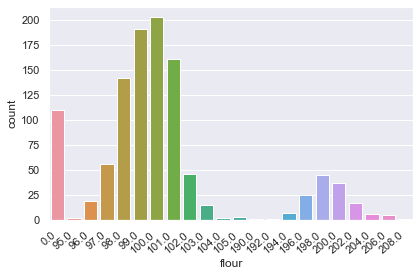

In [7]:
# Die ersten vier Spalten sind die Zutaten für seine Brötchen in den jeweiligen Mengen. Die letzten drei Spalten enthalten
# die Anzahl der Teiglinge, die Anzahl der gebackenen Brötchen (unser Bäcker ist etwas ungeschickt und lässt hin und wieder ein
# Backblech fallen) und die Anzahl der verkauften Brötchen. Wir sehen direkt, dass unser Bäcker am Ende des Tages oft einen
# Überschuss an Brötchen hat die er nicht verkaufen konnte. Für dieses Jupyter Notebook wird es unser Ziel sein dieses Problem
# zu tacklen und ihm dabei zu helfen seine 'Zutatenparameter' so anzupassen, dass er möglichst keinen Überschuss hat.

# Wenden wir uns zunächst dem Preprocessing zu. 
# Zuerst ändern wir die Namen unserer Spalten:
new_names = {
    df.columns[0]: 'flour',
    'Water (l)': 'water',
    'Salt (kg)': 'salt',
    'Yeast (kg)': 'yeast',
    'Kneading Time (min)': 'kneading_time',
    'Nr. unbaked Buns': 'unbaked_buns',
    'Nr. baked Buns': 'baked_buns',
    'Nr. sold Buns': 'sold_buns'
}
df = df.rename(new_names, axis = 'columns')
# Da unser Bäcker wohl kaum jeden einzelnen Tag innerhlab dieser drei Jahre dieselbe Menge an Brötchen gemacht hat, 
# schauen wir uns an wie oft wieviel Mehl verwendet wurde:

ax = sns.countplot(x='flour', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [8]:
# Wir sehen hier, dass am häufigsten ca. 100kg Mehl an einem Tag benutzt wurden. Es gab jedoch auch Tage an denen Mehl im 
# Bereich 200kg verwendet wurde. Schauen wir uns mal einen ersten größeren Teil Datasets an, um herauszufinden wann das der Fall ist:
df.head(50)

flour  water  salt  yeast  kneading_time  unbaked_buns  baked_buns  \
0   100.0   70.0   1.5    1.4           35.0        3458.0      3373.0   
1    99.0   69.0   1.5    1.4           35.0        3418.0      3294.0   
2   101.0   70.0   1.5    1.4           35.0        3478.0      3390.0   
3    98.0   68.0   1.5    1.4           34.0        3378.0      3278.0   
4   100.0   70.0   1.5    1.4           35.0        3458.0      3376.0   
5    97.0   67.0   1.5    1.4           34.0        3338.0      3238.0   
6   208.0  145.0   3.1    2.9           72.0        7180.0      7077.0   
7   100.0   70.0   1.5    1.4           35.0        3458.0      3297.0   
8   101.0   70.0   1.5    1.4           35.0        3478.0      3391.0   
9    97.0   67.0   1.5    1.4           34.0        3338.0      3166.0   
10    0.0    0.0   0.0    0.0            0.0           0.0       -56.0   
11  102.0   71.0   1.5    1.4           36.0        3518.0      3345.0   
12  100.0   70.0   1.5    1.4           35.0        3458.0      3395.0   
13  202.0  141.0   3.0    2.8           70.0        6976.0      6859.0   
14   98.0   68.0   1.5    1.4           34.0        3378.0      3285.0   
15   99.0   69.0   1.5    1.4           35.0        3418.0      3259.0   
16   98.0   68.0   1.5    1.4           34.0        3378.0      3226.0   
17  102.0   71.0   1.5    1.4           36.0        3518.0      3461.0   
18  101.0   70.0   1.5    1.4           35.0        3478.0      3343.0   
19   98.0   68.0   1.5    1.4           34.0        3378.0      3184.0   
20  202.0  141.0   3.0    2.8           70.0        6976.0      6879.0   
21  101.0   70.0   1.5    1.4           35.0        3478.0      3385.0   
22  101.0   70.0   1.5    1.4           35.0        3478.0      3281.0   
23    0.0    0.0   0.0    0.0            0.0           0.0      -130.0   
24  101.0   70.0   1.5    1.4           35.0        3478.0      3413.0   
25   99.0   69.0   1.5    1.4           35.0        3418.0      3293.0   
26  100.0   70.0   1.5    1.4           35.0        3458.0      3317.0   
27  198.0  138.0   3.0    2.8           69.0        6836.0      6749.0   
28  103.0   72.0   1.5    1.4           36.0        3558.0      3393.0   
29   98.0   68.0   1.5    1.4           34.0        3378.0      3271.0   
30   99.0   69.0   1.5    1.4           35.0        3418.0      3280.0   
31  101.0   70.0   1.5    1.4           35.0        3478.0      3321.0   
32  101.0   70.0   1.5    1.4           35.0        3478.0      3365.0   
33   99.0   69.0   1.5    1.4           35.0        3418.0      3352.0   
34  196.0  137.0   2.9    2.7           68.0        6771.0      6672.0   
35   99.0   69.0   1.5    1.4           35.0        3418.0      3320.0   
36   98.0   68.0   1.5    1.4           34.0        3378.0      3280.0   
37   99.0   69.0   1.5    1.4           35.0        3418.0      3219.0   
38  101.0   70.0   1.5    1.4           35.0        3478.0      3412.0   
39  100.0   70.0   1.5    1.4           35.0        3458.0      3283.0   
40  101.0   70.0   1.5    1.4           35.0        3478.0      3394.0   
41  196.0  137.0   2.9    2.7           68.0        6771.0      6643.0   
42  101.0   70.0   1.5    1.4           35.0        3478.0      3317.0   
43  100.0   70.0   1.5    1.4           35.0        3458.0      3396.0   
44  101.0   70.0   1.5    1.4           35.0        3478.0      3367.0   
45   99.0   69.0   1.5    1.4           35.0        3418.0      3333.0   
46  100.0   70.0   1.5    1.4           35.0        3458.0      3297.0   
47   99.0   69.0   1.5    1.4           35.0        3418.0      3349.0   
48  196.0  137.0   2.9    2.7           68.0        6771.0      6587.0   
49    0.0    0.0   0.0    0.0            0.0           0.0      -188.0   

    sold_buns  
0      3180.0  
1      3020.0  
2      3137.0  
3      2970.0  
4      3226.0  
5      3135.0  
6      6818.0  
7      3053.0  
8      3099.0  
9      2877.0  
10     -304.0  
11     3037.0  
12     3158.0  
13   

In [9]:
# Hier lässt sich feststellen, dass an jedem 7ten Tag doppelt so viel Mehl, wie an den anderen Tagen benutzt wird. 
# Unsere Konklusion: Das sind alles Sonntage. An diesen Tagen sind die meisten Supermärkte/Discounter geschlossen und daher
# gehen viele Menschen zu einer klassischen Bäckerei.

# Weiter tritt auch einige Male der Wert Null auf. An diesen Tagen war wohl die Bäckerei geschlossen. Diese Zeilen werden wir daher
# aus dem Dataset entfernen:

df = df[df.flour!= 0]

In [10]:
# Wie wir nun sehen werden verlieren wir dadurch ca. 10% unseres Datasets:
df.shape

(985, 8)

In [11]:
# Schauen wir uns auch mal an was die mittlere Differenz zwischen der Anzahl der gebackenen Brötchen und der Anzahl 
# der verkauften Brötchen ist.
np.ceil(np.mean(np.array(df['baked_buns'].tolist()) - np.array(df['sold_buns'].tolist())))

231.0

In [12]:
# Das Problem unseres Bäckers besteht darin, dass er zu viele Brötchen produziert; im Schnitt 231 Brötchen zu viel. 
# Diese Differenz wollen wir minimieren. 
# Er vertritt hierbei die Philosophie 'Lieber zu viel als zu wenig', was zunächst auch sinnvoll erscheint, 
# aber langfristig verliert er dadurch Ressourcen bei so einem hohen Überschuss.
# Momentan sehen die Verhältnisse der einzelnen Phasen in denen sich die Brötchen befinden so aus:
# unbaked_buns > baked_buns > sold_buns.
# Und was wir erreichen wollen ist folgendes:
# unbaked_buns > baked_buns = sold_buns.
# Dazu möchten wir ihm einen Ratschlag geben können, wie er die Inputmenge an Zutaten verringern kann, sodass er nach dem Backen
# so viele Brötchen zur Verfügung hat wie wahrscheinlich auch über die Theke gehen würden. 
# Daher ist nun die Zeit die es zum Kneten braucht irrelevant:
df = df[df.kneading_time!= 0]

# Da der Bäcker für seinen Teig vermutlich ein Rezept hat ist es evtl. gar nicht notwendig alle Zutatenparameter anzupassen,
# sondern nur z.B. die Menge an Mehl zu verringern und so dementsprechend auch Wasser, Salz und Hefe anzupassen. Eine
# kleine Korrelationsanalyse bestätigt das auch:
df.corr()

flour     water      salt     yeast  kneading_time  \
flour          1.000000  0.999932  0.999064  0.998996       0.999746   
water          0.999932  1.000000  0.998837  0.998768       0.999806   
salt           0.999064  0.998837  1.000000  0.999978       0.998898   
yeast          0.998996  0.998768  0.999978  1.000000       0.998832   
kneading_time  0.999746  0.999806  0.998898  0.998832       1.000000   
unbaked_buns   0.999990  0.999974  0.999022  0.998956       0.999790   
baked_buns     0.999382  0.999350  0.998443  0.998377       0.999198   
sold_buns      0.997704  0.997681  0.996683  0.996616       0.997536   

               unbaked_buns  baked_buns  sold_buns  
flour              0.999990    0.999382   0.997704  
water              0.999974    0.999350   0.997681  
salt               0.999022    0.998443   0.996683  
yeast              0.998956    0.998377   0.996616  
kneading_time      0.999790    0.999198   0.997536  
unbaked_buns       1.000000    0.999386   0.997710  
baked_buns         0.999386    1.000000   0.998278  
sold_buns          0.997710    0.998278   1.000000

In [13]:
# Wir erkennen hier, dass die Parameter paarweise korrelieren. Das ist der Moment an dem man den Hörer in die Hand nimmt und 
# den Bäcker anruft, damit er uns sein Rezept und seinen Brotbackprozess mitteilt. Dabei erzählt er uns, dass er immer zuerst
# die Menge an Mehl festlegt für den Tag und dann dementsprechend die anderen Zutaten hinzufügt. Wie genau er das macht sagt
# er uns auch:

# Mehl
# Wasser = 0.7*Mehl
# Salt = (3/200)*Mehl
# Hefe = (7/500)*Mehl

# Mit der zusätzlichen Information, dass ein Teigling ca. 50g wiegt, können wir uns damit nun eine Funktion schreiben, 
# die uns zu einer gegebenen Menge Mehl die daraus resultierende Anzahl an Teiglingen gibt:

def unbaked_buns_count(Mehl):
    answer = Mehl*(1+ 0.7 + 3/200 + 7/500)/0.05
    return answer

# Lasst uns nun überprüfen wie nah unsere Funktion im Schnitt an den Werten unserer Tabelle ist:
np.mean(unbaked_buns_count(np.array(df['flour'].tolist())) - np.array(df['unbaked_buns'].tolist()))

7.673137055836998

In [18]:
# Unsere Funktion liegt im Schnitt um 8 Teiglinge daneben, was schon recht gut ist.
# Nun möchten wir noch mit Hilfe zweier Neural Networks herausfinden, wie aus 'unbaked_buns' 'baked_buns' und aus 'baked_buns'
# 'sold_buns' resultiert. anschließend verknüpfen wir diese Funktionen und minimieren mit dem Parameter Mehl. Im Folgenden 
# trainieren wir also nun unsere Neural Networks:

IP1 = df['unbaked_buns']
OP1 = df['baked_buns'].values

model1 = keras.Sequential([
    keras.layers.Input((1,)),
    keras.layers.Dense(11, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model1.compile(loss="mse")
model1.fit(IP1,OP1,batch_size=10,epochs=20,validation_split=0.1,shuffle=2)

Train on 886 samples, validate on 99 samples
Epoch 1/20
886/886 [==============================] - 0s 284us/sample - loss: 16038301.8600 - val_loss: 16433944.6970
Epoch 2/20
886/886 [==============================] - 0s 67us/sample - loss: 16038301.8126 - val_loss: 16433944.6970
Epoch 3/20
886/886 [==============================] - 0s 65us/sample - loss: 16038301.9052 - val_loss: 16433944.6970
Epoch 4/20
886/886 [==============================] - 0s 68us/sample - loss: 16038302.0000 - val_loss: 16433944.6970
Epoch 5/20
886/886 [==============================] - 0s 67us/sample - loss: 16038301.8172 - val_loss: 16433944.6970
Epoch 6/20
886/886 [==============================] - 0s 69us/sample - loss: 16038301.9819 - val_loss: 16433944.6970
Epoch 7/20
886/886 [==============================] - 0s 67us/sample - loss: 16038301.9278 - val_loss: 16433944.6970
Epoch 8/20
886/886 [==============================] - 0s 65us/sample - loss: 16038301.8916 - val_loss: 16433944.6970
Epoch 9/20
886/886

In [19]:
IP2 = df['baked_buns']
OP2 = df['sold_buns'].values

model2 = keras.Sequential([
    keras.layers.Input((1,)),
    keras.layers.Dense(11, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model2.compile(loss="mse")
model2.fit(IP1,OP1,batch_size=1,epochs=20,validation_split=0.1,shuffle=2)

Train on 886 samples, validate on 99 samples
Epoch 1/20
886/886 [==============================] - 0s 272us/sample - loss: 16030672.7472 - val_loss: 16426238.3939
Epoch 2/20
886/886 [==============================] - 0s 72us/sample - loss: 16030672.6343 - val_loss: 16426238.3939
Epoch 3/20
886/886 [==============================] - 0s 67us/sample - loss: 16030672.6637 - val_loss: 16426238.3939
Epoch 4/20
886/886 [==============================] - 0s 69us/sample - loss: 16030672.7065 - val_loss: 16426238.3939
Epoch 5/20
886/886 [==============================] - 0s 67us/sample - loss: 16030672.6591 - val_loss: 16426238.3939
Epoch 6/20
886/886 [==============================] - 0s 70us/sample - loss: 16030672.8149 - val_loss: 16426238.3939
Epoch 7/20
886/886 [==============================] - 0s 70us/sample - loss: 16030672.7810 - val_loss: 16426238.3939
Epoch 8/20
886/886 [==============================] - 0s 69us/sample - loss: 16030672.7223 - val_loss: 16426238.3939
Epoch 9/20
886/886

In [20]:
# Nun sind wir fast am Ende. Was wir jetzt noch tun müssen ist die Funktion die die Differenz von gebackenen und verkauften
# Brötchen darstellt zu minimieren in der Variable 'Mehl'.
# Das lässt sich problemlos mit 'minimize' aus der Bibliothek 'scipy.optimize' erledigen. Der Wert bzw. die Menge an Mehl
# die diese funktion minimiert sollte der Bäcker dann in Zukunft an seinen Arbeitstagen anpeilen.

In [21]:
# Ihr konntet dem Bäcker anders unter die Arme greifen? 
# Dann lasst es uns wissen und schriebt uns direkt an podcast@erium.de, auf LinkedIn, Facebook, Twitter oder Instagram!

# Danke fürs anschauen dieser Jupyter Notebook Datei und Hören des Podcasts. Seid auch gespannt auf die nächste Folge von 
# The Erium Podcast in der wir euch alles über NETWORKING in der Arbeitswelt verraten! :D